In [14]:
import pylab
import pymoc
import xidplus
import numpy as np
%matplotlib inline
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
import seaborn as sns

This notebook uses all the raw data from the XID+MIPS catalogue, maps, PSF and relevant MOCs to create XID+ prior object and relevant tiling scheme

## Read in MOCs
The selection functions required are the main MOC associated with the masterlist. As the prior for XID+ is based on IRAC detected sources coming from two different surveys at different depths (SWIRE and SPUDS) I will split the XID+ run into two different runs.

In [15]:
Sel_func=pymoc.MOC()
Sel_func.read('../../dmu4/dmu4_sm_XMM-LSS/data/holes_XMM-LSS_irac1_O16_20180420_MOC.fits')
SWIRE_MOC=pymoc.MOC()
SWIRE_MOC.read('../../dmu0/dmu0_DataFusion-Spitzer/data/Sub_wp4_xmm-lss_mips24_map_v1-1-_MOCmips_mosaic_MOC.fits')
Final=Sel_func.intersection(SWIRE_MOC)


In [16]:
#pymoc.io.fits.write_moc_fits(Final, 'SWIREnSPUDS.fits')

## Read in XID+MIPS catalogue

In [17]:
XID_MIPS=Table.read('../dmu26_XID+MIPS_XMM-LSS/data/dmu26_XID+MIPS_XMM-LSS_SWIREnSPUDS_concat_20190106.fits')

In [18]:
XID_MIPS[0:10]

help_id,RA,Dec,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24
,degrees,degrees,muJy,muJy,muJy,MJy / sr,MJy / sr,,,,
bytes27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,bool
HELP_J021846.087-062301.346,34.692030947564795,-6.383707158297614,30.09487,46.226128,14.67685,-0.0009270066,4.858147e-06,nan,1142.0,0.0,False
HELP_J021843.070-062345.559,34.6794586722776,-6.39598871477323,4170.4424,4190.5127,4150.0,-0.0009270066,4.858147e-06,nan,2000.0,0.373,False
HELP_J021852.610-062138.457,34.7192093322776,-6.36068236477323,327.6509,346.8575,307.92105,-0.0046012965,4.779417e-06,nan,1248.0,0.0,False
HELP_J021854.601-062151.326,34.7275025122776,-6.36425716477323,65.46506,83.40683,47.538906,-0.0046012965,4.779417e-06,nan,1179.0,0.398,False
HELP_J021851.714-062215.569,34.7154747122776,-6.3709913347732305,3.1386747,7.2766647,0.9495287,-0.0046012965,4.779417e-06,nan,1711.0,0.0,True
HELP_J021911.572-062135.966,34.7982186822776,-6.359990434773231,554.56165,571.6919,537.1004,-0.012682672,4.8390184e-06,nan,555.0,0.0,False
HELP_J021917.826-062026.091,34.8242763422776,-6.34058070477323,963.8944,982.96875,944.89764,-0.005463596,4.9658024e-06,nan,893.0,0.011,False
HELP_J021923.350-061946.651,34.8472902722776,-6.32962525477323,2255.2812,2275.3945,2235.6658,0.0036527414,4.8568736e-06,nan,2000.0,0.0,False


4.987116
630


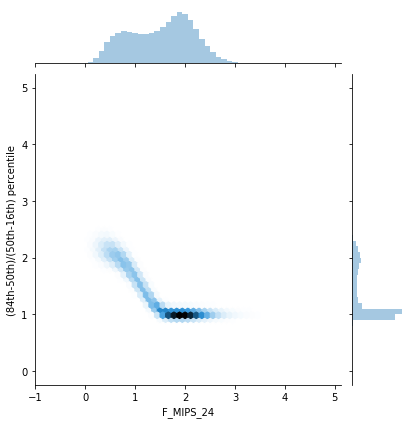

In [19]:
skew=(XID_MIPS['FErr_MIPS_24_u']-XID_MIPS['F_MIPS_24'])/(XID_MIPS['F_MIPS_24']-XID_MIPS['FErr_MIPS_24_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
use = skew < 5 
n_use=skew>5
g=sns.jointplot(x=np.log10(XID_MIPS['F_MIPS_24'][use]),y=skew[use] ,kind='hex')
print(np.max(skew[use]))
print(len(skew[n_use]))


The uncertianties become Gaussian by $\sim 20 \mathrm{\mu Jy}$

In [20]:
good=XID_MIPS['F_MIPS_24']>20
print(len(good))

461805


In [21]:
good.sum()

287595

## Read in Maps

In [22]:
pswfits='../../dmu19/dmu19_HELP-SPIRE-maps/data/XMM-LSS_SPIRE250_v1.0.fits'#SPIRE 250 map
pmwfits='../../dmu19/dmu19_HELP-SPIRE-maps/data/XMM-LSS_SPIRE350_v1.0.fits'#SPIRE 350 map
plwfits='../../dmu19/dmu19_HELP-SPIRE-maps/data/XMM-LSS_SPIRE500_v1.0.fits'#SPIRE 500 map

#output folder
output_folder='./data/'

In [23]:

#-----250-------------
hdulist = fits.open(pswfits)
im250phdu=hdulist[0].header
im250hdu=hdulist['IMAGE'].header

im250=hdulist['IMAGE'].data*1.0E3 #convert to mJy
nim250=hdulist['ERROR'].data*1.0E3 #convert to mJy
w_250 = wcs.WCS(hdulist['IMAGE'].header)
pixsize250=3600.0*w_250.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()
#-----350-------------
hdulist = fits.open(pmwfits)
im350phdu=hdulist[0].header
im350hdu=hdulist['IMAGE'].header

im350=hdulist['IMAGE'].data*1.0E3 #convert to mJy
nim350=hdulist['ERROR'].data*1.0E3 #convert to mJy
w_350 = wcs.WCS(hdulist['IMAGE'].header)
pixsize350=3600.0*w_350.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()
#-----500-------------
hdulist = fits.open(plwfits)
im500phdu=hdulist[0].header
im500hdu=hdulist['IMAGE'].header

im500=hdulist['IMAGE'].data*1.0E3 #convert to mJy
nim500=hdulist['ERROR'].data*1.0E3 #convert to mJy
w_500 = wcs.WCS(hdulist['IMAGE'].header)
pixsize500=3600.0*w_500.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()

In [24]:
## Set XID+ prior class

In [25]:
#---prior250--------
prior250=xidplus.prior(im250,nim250,im250phdu,im250hdu, moc=Final)#Initialise with map, uncertianty map, wcs info and primary header
prior250.prior_cat(XID_MIPS['RA'][good],XID_MIPS['Dec'][good],'dmu26_XID+MIPS_XMM-LSS_SWIREnSPUDS_cat_20190106.fits',ID=XID_MIPS['help_id'][good])#Set input catalogue
prior250.prior_bkg(-5.0,5)#Set prior on background (assumes Gaussian pdf with mu and sigma)
#---prior350--------
prior350=xidplus.prior(im350,nim350,im350phdu,im350hdu, moc=Final)
prior350.prior_cat(XID_MIPS['RA'][good],XID_MIPS['Dec'][good],'dmu26_XID+MIPS_XMM-LSS_SWIREnSPUDS_cat_20190106.fits',ID=XID_MIPS['help_id'][good])
prior350.prior_bkg(-5.0,5)

#---prior500--------
prior500=xidplus.prior(im500,nim500,im500phdu,im500hdu, moc=Final)
prior500.prior_cat(XID_MIPS['RA'][good],XID_MIPS['Dec'][good],'dmu26_XID+MIPS_XMM-LSS_SWIREnSPUDS_cat_20190106.fits',ID=XID_MIPS['help_id'][good])
prior500.prior_bkg(-5.0,5)

In [26]:
#pixsize array (size of pixels in arcseconds)
pixsize=np.array([pixsize250,pixsize350,pixsize500])
#point response function for the three bands
prfsize=np.array([18.15,25.15,36.3])
#use Gaussian2DKernel to create prf (requires stddev rather than fwhm hence pfwhm/2.355)
from astropy.convolution import Gaussian2DKernel

##---------fit using Gaussian beam-----------------------
prf250=Gaussian2DKernel(prfsize[0]/2.355,x_size=101,y_size=101)
prf250.normalize(mode='peak')
prf350=Gaussian2DKernel(prfsize[1]/2.355,x_size=101,y_size=101)
prf350.normalize(mode='peak')
prf500=Gaussian2DKernel(prfsize[2]/2.355,x_size=101,y_size=101)
prf500.normalize(mode='peak')

pind250=np.arange(0,101,1)*1.0/pixsize[0] #get 250 scale in terms of pixel scale of map
pind350=np.arange(0,101,1)*1.0/pixsize[1] #get 350 scale in terms of pixel scale of map
pind500=np.arange(0,101,1)*1.0/pixsize[2] #get 500 scale in terms of pixel scale of map

prior250.set_prf(prf250.array,pind250,pind250)#requires psf as 2d grid, and x and y bins for grid (in pixel scale)
prior350.set_prf(prf350.array,pind350,pind350)
prior500.set_prf(prf500.array,pind500,pind500)

In [27]:
import pickle
#from moc, get healpix pixels at a given order
from xidplus import moc_routines
order=9
tiles=moc_routines.get_HEALPix_pixels(order,prior250.sra,prior250.sdec,unique=True)
order_large=6
tiles_large=moc_routines.get_HEALPix_pixels(order_large,prior250.sra,prior250.sdec,unique=True)
print('----- There are '+str(len(tiles))+' tiles required for input catalogue and '+str(len(tiles_large))+' large tiles')
output_folder='./data/'
outfile=output_folder+'Master_prior_SWIRE.pkl'
with open(outfile, 'wb') as f:
    pickle.dump({'priors':[prior250,prior350,prior500],'tiles':tiles,'order':order,'version':xidplus.io.git_version()},f)
outfile=output_folder+'Tiles_SWIRE.pkl'
with open(outfile, 'wb') as f:
    pickle.dump({'tiles':tiles,'order':order,'tiles_large':tiles_large,'order_large':order_large,'version':xidplus.io.git_version()},f)
raise SystemExit()

----- There are 697 tiles required for input catalogue and 21 large tiles


SystemExit: 